# Spectrum and light curve from DL3

This notebook must be used with gammapy version v1.1, which is already installed in the school conda environment.

If you are running in the IT Container, you can follow the instructions on the indico page: https://indico.cta-observatory.org/event/5272/attachments/24779/36254/Remote_jupyter_notebook.pdf

In this tutorial, we use `gammapy` to analyze Crab Nebula observations collected with MAGIC and LST 1, and reduced up to data level 3 (DL3) with the magic-cta-pipe (MCP). Our main goals are to produce:
1) A counts map.
2) The signal excess significance.
3) A spectral energy distribution (SED).
4) A light curve.

We will then fit the SED with a LogParabola model given by  

## $ \Phi =  \Phi_0 \left(\frac{E}{E_{ref}}\right)^{\alpha + \beta\log_{10}(E/E_{ref})}     $

and compare it with the archival Crab spectrum, which has $\Phi_0 = 3.23\times 10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$, $E_{ref} = 1$ TeV, $\alpha = -2.47$, and $\beta = -0.24$.



### Let's start by loading some modules and checking the `gammapy` version

In [55]:
import itertools
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib import pyplot as plt
import gammapy
from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import ReflectedRegionsBackgroundMaker, SafeMaskMaker, SpectrumDatasetMaker, WobbleRegionsFinder
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (ExpCutoffPowerLawSpectralModel, LogParabolaSpectralModel, 
    PowerLawSpectralModel, SkyModel, create_crab_spectral_model)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from regions import CircleSkyRegion, PointSkyRegion

print(f"gammapy: v{gammapy.__version__}")

gammapy: v1.1


In [56]:
# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "--"}
)

# Get the default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load DL3 files

Here we load the DL3 files into `gammapy` data containers (i.e.: **DataStore objects**) .

First we need to provide the directories where the DL3 and index files are stored.

The meaning of the following directory's labels are:  
*_new*: data reduced with cta-pipe 0.19 and MCP 0.4.1.  
*_old*: data reduced with cta-pipe 0.12 and MCP 0.3.0.  

In this example, we use the data available in the following directories in the IT Container:

`/fefs/aswg/workspace/analysis-school-2024/MCP/dl4/new/`  

`/fefs/aswg/workspace/analysis-school-2024/MCP/dl4/old/`  

The data files in these directories look like "dl3_MAGIC_LST-1.Run0XXXX.fits.gz", where XXXX is the number of the run. Each one of these files contain six tables with data on the 1) effective area, 2) energy dispersion, 3) gammaness cut, 4) all the events that survived the analysis, 5) the good time interval, and 6) the pointing information.

It is possible to run this notebook on a single dataset or both. Running on both allows to check the differences in the data reduction between the two versions of the pipelines. If you wish to process only the new set of DL3 files, please set `input_dir_old = ""` below.

Let's start by creating DataStore objects from the input directories and taking a look at one of them.

In [97]:
input_dir = './data_new/'
input_dir_old = './data_old/'

double = True
if input_dir_old=='':
    double = False
    
data_store = DataStore.from_dir(input_dir)
if double:
    data_store_old = DataStore.from_dir(input_dir_old)
    
# Show the observation table
print("Information for each one of the 16 runs:")
data_store.obs_table


Information for each one of the 16 runs:


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes10,bytes10
2923,2020-11-18,23:35:47.054,2020-11-18,23:52:39.650,83.9655824956356,22.24638258303725,45.06181680322297,44.93818319677703,86.4042617437209,83.6287,22.0147,1605742547.053724,1605743559.6495488,1008.4129841327667,1012.5958247184706,914.9879314280009,0.9073543734811079,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
2924,2020-11-18,23:56:14.778,2020-11-19,00:15:55.933,83.26501544049681,21.787690829509234,40.103412342808156,49.896587657191844,89.65985731540093,83.6287,22.0147,1605743774.7776647,1605744955.9328632,1166.8362052440643,1181.155198574065,1059.4696497470868,0.9079848953825358,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3093,2020-12-07,23:34:47.459,2020-12-07,23:36:13.629,83.97865725299596,22.24532178487609,28.895382633872885,61.104617366127115,95.7573997585375,83.6287,22.0147,1607384087.4587543,1607384173.6294522,86.55207657814026,86.17069792747358,81.4376904628313,0.9409097237465859,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3265,2020-12-15,21:27:18.415,2020-12-15,21:41:43.146,83.96475782787196,22.247863564717495,49.9494782005039,40.0505217994961,84.08107653962642,83.6287,22.0147,1608067638.4148557,1608068503.1457675,855.0063529014587,864.7309117317188,813.664040700302,0.9516467777568415,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3266,2020-12-15,21:43:24.497,2020-12-15,21:57:30.479,83.26300701345083,21.787702297229966,45.962273897759275,44.037726102240725,86.64186055227022,83.6287,22.0147,1608068604.4967954,1608069450.4792976,836.1575503349304,845.9825022220609,796.7032716627156,0.9528147791568573,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3267,2020-12-15,21:59:19.731,2020-12-15,22:12:55.664,83.96675057060591,22.246063026478925,42.93517607753816,47.06482392246184,87.45572611833191,83.6287,22.0147,1608069559.7313616,1608070375.6639178,805.7898585796356,815.932556152341,768.3716700864201,0.953563341490581,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,2021-02-13,23:09:15.761,2021-02-13,23:25:57.551,83.28785232025376,21.786736575154677,27.93920269216776,62.06079730783224,262.4862245311674,83.6287,22.0147,1613257755.7612557,1613258757.5513155,1002.0773997306824,1001.7900598049156,965.7542084304719,0.9637521100565957,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2


This gives us the general information on each one of the runs, as the start and end times of observation and the average pointing RA and Dec.

Here we are using all available runs (equivalent to `obs_ids = None`), however, if some of these runs are not good (e.g.: let's say that the exposure time was interrupted after a few seconds of observations for a couple of runs), we can select specific runs by setting `obs_ids` as a list of runs. Here we use the `gammapy` function `get_observations()` to select all 16 runs:

In [58]:
obs_ids = [2923, 2924, 3093, 3265, 3266, 3267, 3268, 3631, 3633, 3634, 3635, 3636, 4069, 4070, 4071, 4125]
obs_ids_old = [2923, 2924, 3093, 3265, 3266, 3267, 3268, 3631, 3633, 3634, 3635, 3636, 4069, 4070, 4071, 4125]

observations = data_store.get_observations(obs_ids, required_irf="point-like")
if double:
    observations_old = data_store_old.get_observations(obs_ids_old, required_irf="point-like")

print(observations)

Observations
Number of observations: 16
Observation

	obs id            : 2923 
 	tstart            : 59171.98
	tstop             : 59171.99
	duration          : 1012.60 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 9.3%
Observation

	obs id            : 2924 
 	tstart            : 59172.00
	tstop             : 59172.01
	duration          : 1181.16 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 9.2%
Observation

	obs id            : 3093 
 	tstart            : 59190.98
	tstop             : 59190.98
	duration          : 86.17 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 5.9%
Observation

	obs id            : 3265 
 	tstart            : 59198.89
	tstop             : 59198.90
	duration          : 864.73 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 4.8%
Observation

	obs id            : 3266 
 	tstart            : 59198.90
	tstop             : 59198.91
	duration          : 845.98 s
	pointing (icrs)   : 83.3 deg, 21.8 

### Define the ON region

Here we will collect the target position from observations metadata. To define the `on_region` we use `CircleSkyRegion` in the case of global theta cuts or `PointSkyRegion` in the case of dynamic theta cuts.

In [59]:
# Get metadata from the new data
observation = observations[0]
event_meta = observation.events.table.meta
aeff_meta = observation.aeff.meta

# Collecting the target position
target_position = SkyCoord(
    u.Quantity(event_meta["RA_OBJ"], u.deg),
    u.Quantity(event_meta["DEC_OBJ"], u.deg),
    frame="icrs",
)

if "RAD_MAX" in aeff_meta:
    print("Using global theta cut:")
    # Get the global theta cut used for creating the IRFs
    on_region_radius = aeff_meta["RAD_MAX"] * u.deg
    
    # Use the circle sky region to apply the global theta cut
    on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
    
else:
    print("Using dynamic theta cut:")
    # Use the point sky region to apply dynamic theta cuts
    on_region = PointSkyRegion(target_position)
    
print("Position of the ON region: \n",on_region)

Using global theta cut:
Position of the ON region: 
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.6287, 22.0147)>
radius: 0.2 deg


Since we are using the same observations reduced with two versions of the same pipeline, the ON region of the old data is identical to the new data:

In [60]:
if double:
    target_position_old = target_position
    on_region_old = on_region

### Running the data reduction chain

Here we create the energy axes and set the number of OFF regions per run.

We also create the Gammapy **Makers** needed to process the data.

In [61]:
# ================
# === Settings ===
# ================

energy_reco_min = "0.030 TeV" # reconstructed energy minimum
energy_reco_max = "30. TeV" # reconstructed energy maximum
n_bins_pdec = 5  # Number of energy bins in the SED


true_energy_min = "0.01 TeV"  # Definition of the range of true energies
true_energy_max = "100 TeV"
n_bins_pdec_true = 10

n_off_regions = 3  # Number of OFF regions for each run.

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(energy_reco_min,energy_reco_max,nbin=n_bins_pdec,
                                            per_decade=True,name="energy")

energy_axis_true = MapAxis.from_energy_bounds(true_energy_min,true_energy_max,nbin=n_bins_pdec_true,
                                            per_decade=True, name="energy_true")


on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])

# Creates an empty dataset with the geometry defined above:
dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

# Create a spectrum dataset maker object
dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=["counts", "exposure", "edisp"],
    use_region_center=True)

# Create a background maker
print(f"\nNumber of OFF regions per run: {n_off_regions}")

region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# Create a safe mask maker
# This mask below serves to cut off the low-energy data for which the effective area is < 10% of its maximum value. 
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)


Number of OFF regions per run: 3


Below we create new makers for the second data sample:

In [62]:
if double:
    on_geom_old = RegionGeom.create(region=on_region_old, axes=[energy_axis])
    dataset_empty_old = SpectrumDataset.create(geom=on_geom_old, energy_axis_true=energy_axis_true)
    # Create a spectrum dataset maker
    dataset_maker_old = SpectrumDatasetMaker(containment_correction=False, selection=["counts", "exposure", "edisp"],
        use_region_center=True)

    # Create a background maker
    print(f"\nNumber of OFF regions: {n_off_regions}")

    region_finder_old = WobbleRegionsFinder(n_off_regions=n_off_regions)
    bkg_maker_old = ReflectedRegionsBackgroundMaker(region_finder=region_finder_old)

    # Create a safe mask maker
    safe_mask_maker_old = SafeMaskMaker(methods=["aeff-max"], aeff_percent=3)


Number of OFF regions: 3


Now we apply the makers to the observations to create new datasets that contain the number of events, number of excess and background events, exposure and $\delta = 1/R_{OFF}$, where $R_{OFF}$ is the number of OFF regions. We will use this $\delta$ later to compute the Li & Ma significance.


In [63]:
# Class that holds a list of datasets:
datasets = Datasets()

# Create an empty map object:
counts = Map.create(skydir=target_position, width=3)

# Loop over every observation
print("Running the makers...")

n_observations = len(observations)

for i_obs, observation in enumerate(observations):
    
    if (i_obs % 10) == 0:
        print(f"{i_obs}/{n_observations}")
    
    obs_id = observation.obs_id
    
    # Fill all the events in the map created above:
    counts.fill_events(observation.events)

    # Run the makers to the observation data
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

print(f"{n_observations}/{n_observations}")

# Get the information table
info_table = datasets.info_table(cumulative=True)
info_table

Running the makers...
0/16
10/16
16/16


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,298,249.3333282470703,18.650019659334056,48.66666793823242,111.00000248104331,111.00000248104331,nan,819.6277465820312,288550272.0,918.7832501270136,1012.5958247184706,0.32434200336020946,0.052968605959571737,0.2713733932487365,15,11,wstat,362.6452889378854,146,11.0,33.0,0.3333333432674408
stacked,653,561.3333129882812,28.996249565727407,91.66667175292969,232.00000044144667,232.00000044144667,nan,7518.68798828125,559079424.0,1991.2543295348244,2193.7510232925356,0.32793400135508904,0.046034637762391646,0.28189935592979426,15,11,wstat,868.1423570821136,275,11.0,33.0,0.3333333432674408
stacked,689,592.0,29.758663653132768,97.00001525878906,245.0000048223879,245.0000048223879,nan,100.69896697998047,573588160.0,2072.333177116814,2279.921721220009,0.33247549554680617,0.04680715259972954,0.28566835031017307,15,12,wstat,916.7275513590515,291,12.0,35.999996185302734,0.3333333730697632
stacked,1020,856.6666870117188,34.7377651605072,163.3333282470703,377.50002044066736,377.50002044066736,nan,100.69896697998047,892216192.0,2895.25156289304,3144.6526329517283,0.35230099279552035,0.05641420950788185,0.29588678855791944,15,12,wstat,1268.8849399227192,490,12.0,36.000003814697266,0.3333333134651184
stacked,1311,1107.0,39.76353908720449,204.0,480.75002593360773,480.75002593360773,nan,100.69896697998047,1152845568.0,3701.3161939183187,3990.6351351737894,0.3541983260317293,0.05511552899349563,0.29908279703823365,15,12,wstat,1659.177353640664,612,12.0,36.0,0.3333333432674408
stacked,1581,1327.3333740234375,43.21912305778107,253.6666717529297,585.5000314265482,585.5000314265482,nan,100.69896697998047,1378554368.0,4479.359568593896,4806.56769132613,0.35295224145095533,0.05663012041530694,0.2963221312550484,15,12,wstat,1950.9298167751272,761,12.0,36.0,0.3333333432674408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,3053,2539.66650390625,59.087707531261096,513.3333740234375,1148.2500686477852,1148.2500686477852,nan,10621.16796875,2077093504.0,8464.296303438654,8961.654604911793,0.3606915318831297,0.06064690502563028,0.3000446124357084,15,13,wstat,3706.8180177319505,1540,13.0,38.999996185302734,0.3333333730697632


Again for the second sample:

In [64]:
if double:
    datasets_old = Datasets()

    counts_old = Map.create(skydir=target_position_old, width=3)

    # Loop over every observation
    print("Running the makers...")

    n_observations_old = len(observations_old)

    for i_obs, observation in enumerate(observations_old):

        if (i_obs % 10) == 0:
            print(f"{i_obs}/{n_observations_old}")

        obs_id = observation.obs_id

        # Fill the number of events in the map
        counts_old.fill_events(observation.events)

        # Run the makers to the observation data
        dataset = dataset_maker_old.run(dataset_empty_old.copy(name=str(obs_id)), observation)
        dataset_on_off = bkg_maker_old.run(dataset, observation)
        dataset_on_off = safe_mask_maker_old.run(dataset_on_off, observation)

        datasets_old.append(dataset_on_off)

    print(f"{n_observations_old}/{n_observations_old}")

    # Get the information table
    info_table_old = datasets_old.info_table(cumulative=True)
    info_table_old

Running the makers...
0/16
10/16
16/16


### Sky map

Let's create a counts map showing also the ON-OFF regions for each run.
In the legend, we list the run number for each set of OFF regions.

/home/raniere/miniforge3/envs/magic-lst1/lib/python3.11/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
/home/raniere/miniforge3/envs/magic-lst1/lib/python3.11/site-packages/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


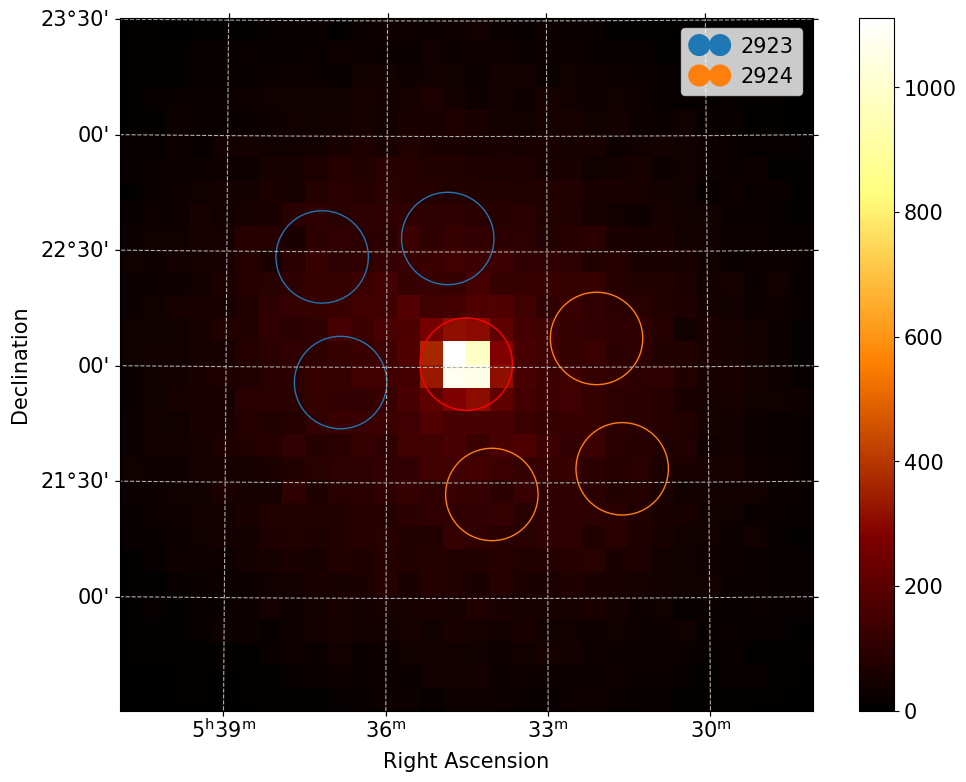

In [65]:
plt.figure()

# Plot the counts map
ax = counts.plot(add_cbar=True)

# Plot the ON position
on_geom.plot_region(ax=ax, edgecolor="red")

# Plot the OFF positions (only the first two runs)
if n_observations < 4:
    plot_spectrum_datasets_off_regions(datasets, ax)
else:
    plot_spectrum_datasets_off_regions(datasets[0:2], ax)

ax.grid()

### Excess significance

Now let's plot the number of events and significance (i.e. sqrt(TS), in $\sigma$ units) as a function of livetime, which is the usefull time collecting data from the target, i.e. livetime $= t_{on} - t_{dead}$.

As expected, the number of excess events (and so the significance) increase faster than the background in terms of the livetime, reaching a 50 $\sigma$ significance in less than 2 hours.

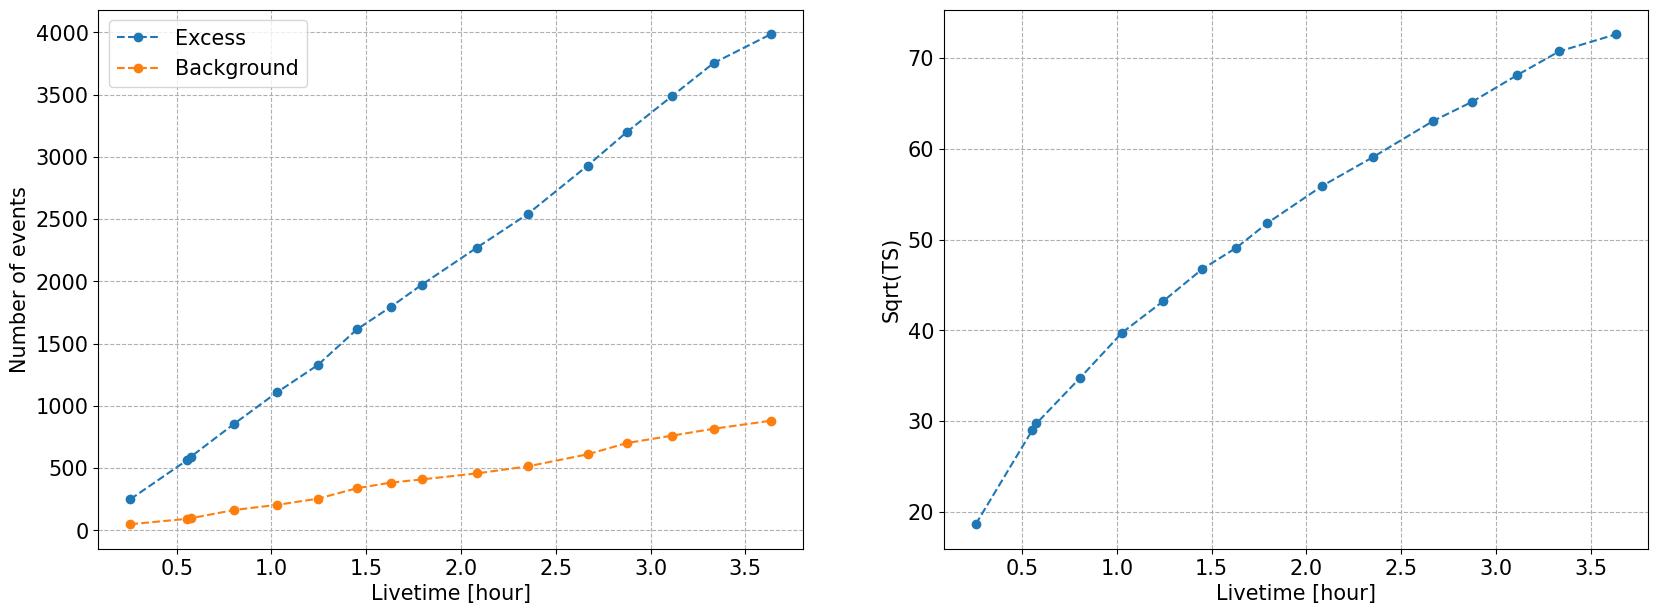

In [66]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Plot the number of events along the livetime
plt.subplot2grid(grid, (0, 0))
plt.xlabel("Livetime [hour]")
plt.ylabel("Number of events")

plt.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    linestyle="--",
    label="Excess",
)

plt.plot(
    info_table["livetime"].to("h"),
    info_table["background"],
    marker="o",
    linestyle="--",
    label="Background",
)

plt.grid()
plt.legend()

# Plot the significance along the livetime
plt.subplot2grid(grid, (0, 1))
plt.xlabel("Livetime [hour]")
plt.ylabel("Sqrt(TS)")

plt.plot(
    info_table["livetime"].to("h"), info_table["sqrt_ts"], marker="o", linestyle="--"
)

plt.grid()

### Fitting the spectrum

We now fit the LogParabola model defined in the top of this notebook to our data. We start by creating a `SkyModel` and adding it to our datasets. We then instantiate the class `Fit` in the default mode, with MINUIT as the minimizer.

In [99]:
source_name = "Crab Nebula"

# Setting the log parabola with initial parameter values
spectral_model = LogParabolaSpectralModel(amplitude=u.Quantity(5e-12, unit="cm-2 s-1 TeV-1"),
    alpha=2, beta=0.1, reference=u.Quantity(1, unit="TeV"))

sky_model = SkyModel(spectral_model=spectral_model.copy(), name=source_name)

# Add the model to the stacked dataset
stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = [sky_model]

if double:    
    stacked_dataset_old = datasets_old.stack_reduce()
    stacked_dataset_old.models = [sky_model]

# Create a fit object to run on the datasets
fit = Fit()

Here we apply the `fit` on the first sample to get the LogParabola parameters:

In [100]:
results = fit.run(datasets=stacked_dataset)
print(results)

# Keep the best fit model
best_fit_model = stacked_dataset.models[0].spectral_model.copy()

# Show the table with fitted parameters
stacked_dataset.models.to_parameters_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 167
	total stat : 13.91

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab Nebula,spectral,amplitude,3.7095e-11,TeV-1 s-1 cm-2,1.013e-12,nan,nan,False,True,
Crab Nebula,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
Crab Nebula,spectral,alpha,2.5044e+00,,2.771e-02,nan,nan,False,False,
Crab Nebula,spectral,beta,1.2888e-01,,1.789e-02,nan,nan,False,False,


Same for the second sample:

In [101]:
if double:    
    results_old = fit.run(datasets=stacked_dataset_old)
    print(results_old)

    # Keep the best fit model
    best_fit_model_old = stacked_dataset_old.models[0].spectral_model.copy()

    # Show the fitted parameters
    stacked_dataset_old.models.to_parameters_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 70
	total stat : 5.08

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



Now let's check if the observations are in good agreement with the fitted log-parabola model. We do it by plotting the number of excess events and comparing it to the number of predicted events based on the log-parabola fit.

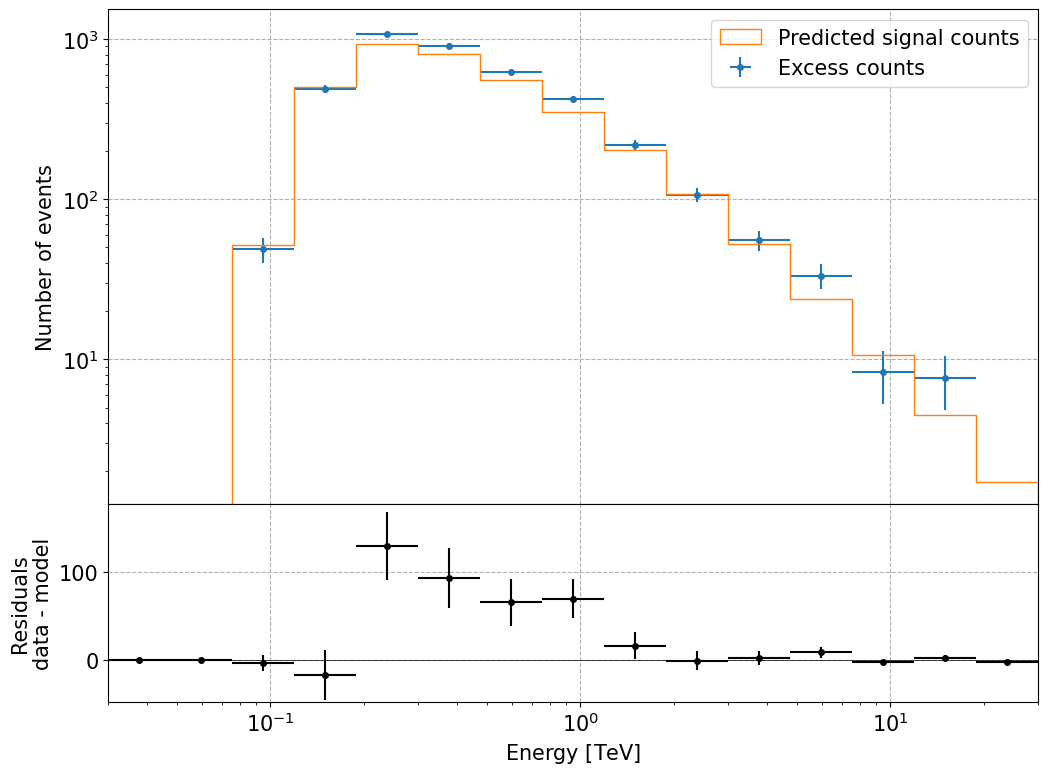

In [102]:
plt.figure()

# Plot the number of excess and predicted events
ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel("Number of events")
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

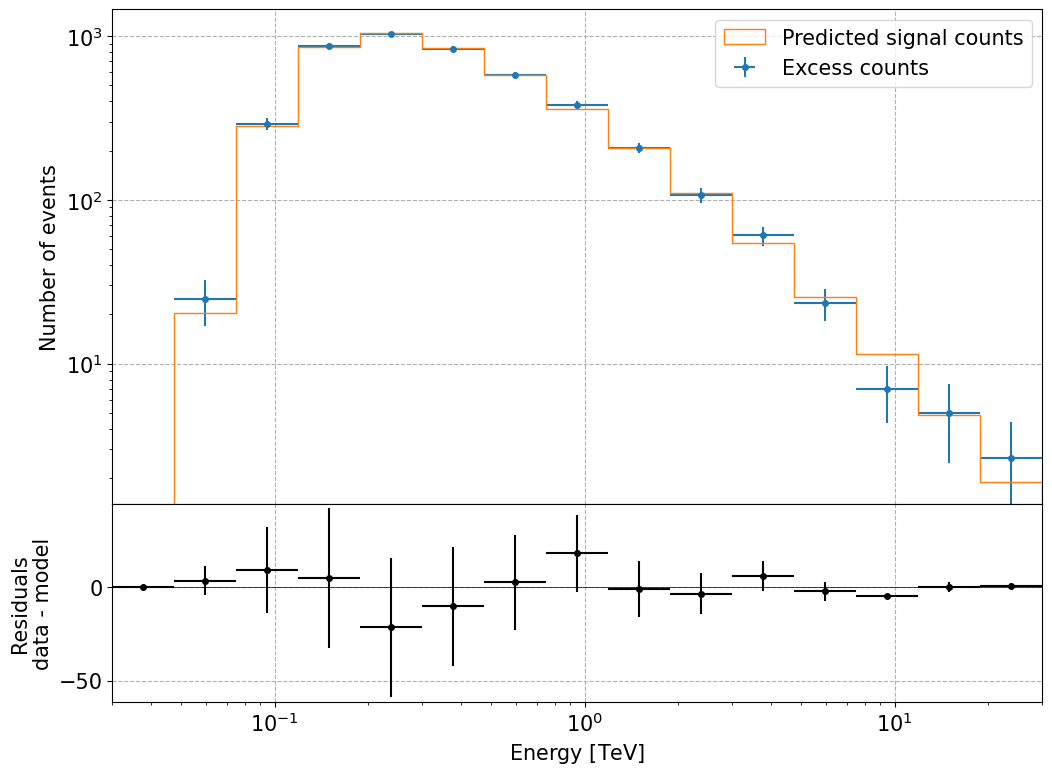

In [103]:
if double:
    plt.figure()

    # Plot the number of excess and predicted events
    ax_spectrum, ax_residuals = stacked_dataset_old.plot_fit()

    ax_spectrum.set_ylabel("Number of events")
    ax_spectrum.grid()

    plt.setp(ax_spectrum.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

    ax_residuals.grid()

### Estimating the flux points

We create a `FluxPointsEstimator` object to be applied on our datasets in order to evaluate the SEDs (`sed_type="e2dnde"`)

In [104]:
# Create a flux point estimator
flux_points_estimator = FluxPointsEstimator(energy_edges=energy_axis.edges, 
                                            source=source_name, selection_optional="all")

For the first data sample we have:

In [105]:
# Run the flux point estimator to the datasets
print("Running the flux points estimator...")
flux_points = flux_points_estimator.run(datasets=stacked_dataset)

# Show the flux points table
flux_points.to_table(sed_type="e2dnde", formatted=True)

Running the flux points estimator...


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.038,0.030,0.048,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.060,0.048,0.075,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.095,0.075,0.119,5.693e-11,1.045e-11,1.079e-11,1.012e-11,7.924e-11,43.076,6.563,72.00265292320884,48.669605,0.000,False,72.0,True,0.200 .. 5.000,24.843 .. 218.444
0.150,0.119,0.189,5.585e-11,3.227e-12,3.261e-12,3.194e-12,6.244e-11,437.488,20.916,711.0070913910774,485.34116,0.000,False,711.0,True,0.200 .. 5.000,255.172 .. 2111.182
0.238,0.189,0.300,6.154e-11,2.203e-12,2.220e-12,2.185e-12,6.602e-11,1269.847,35.635,1374.9951154565392,1073.328,0.000,False,1375.0,True,0.200 .. 5.000,803.132 .. 3607.309
0.378,0.300,0.475,5.324e-11,1.986e-12,2.004e-12,1.968e-12,5.728e-11,1265.416,35.573,1078.9971291928669,903.99695,0.000,False,1079.0,True,0.200 .. 5.000,782.427 .. 3281.659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.383,1.893,3.000,1.941e-11,1.990e-12,2.048e-12,1.932e-12,2.362e-11,192.887,13.888,116.99984658810617,106.99984,0.000,False,117.0,True,0.200 .. 5.000,109.423 .. 495.415


While for the second:

In [106]:
if double:
    # Run the flux point estimator to the datasets
    print("Running the flux points estimator...")
    flux_points_old = flux_points_estimator.run(datasets=stacked_dataset_old)
    
    flux_points_old.to_table(sed_type="e2dnde", formatted=True)

Running the flux points estimator...


### Computing the SED

Below we show the SEDs for the two datasets in the same plot, showing the flux points and best fit models. For comparison, we plot the Crab reference SED (MAGIC, JHEAp 2015).

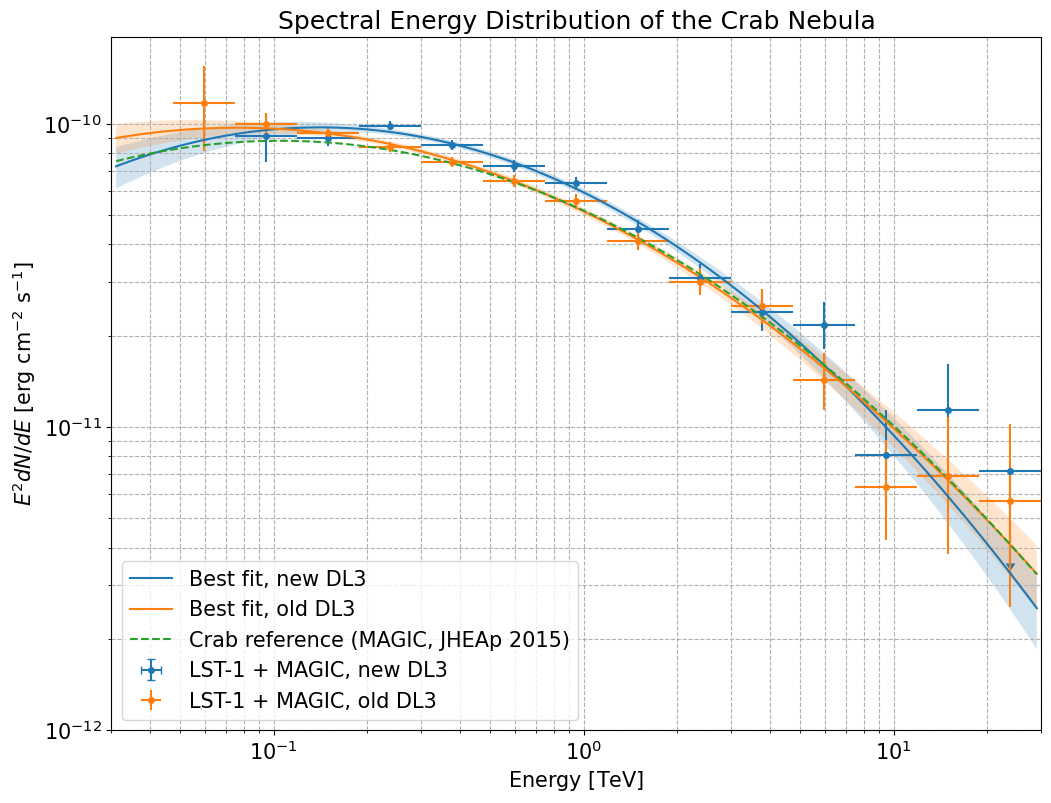

In [107]:
# ================
# === Settings ===
# ================

sed_type = "e2dnde"
yunits = u.Unit("erg cm-2 s-1")

crab_model = create_crab_spectral_model("magic_lp")
#print(crab_model)
reference_models = {"Crab reference (MAGIC, JHEAp 2015)": crab_model}

# ============
# === Main ===
# ============

plt.figure()

energy_bounds = energy_axis.edges[[0, -1]]

lines = itertools.cycle(["--", "-.", ":"])

# Plot the flux points
ax = flux_points.plot(sed_type=sed_type, label="LST-1 + MAGIC, new DL3")
if double:
    ax = flux_points_old.plot(sed_type=sed_type, label="LST-1 + MAGIC, old DL3")


# Plot the best fit model and its error, first sample
best_fit_model.plot(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    color=colors[0],
    label="Best fit, new DL3"
)

best_fit_model.plot_error(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    facecolor=colors[0],
)

if double:
    # Plot the best fit model and its error, second sample
    best_fit_model_old.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        color=colors[1],
        label="Best fit, old DL3 "
    )

    best_fit_model_old.plot_error(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        facecolor=colors[1],
    )


# Plot the reference spectra
for label, model in reference_models.items():

    model.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        label=label,
        linestyle=next(lines)
    )

ax.set_title(f"Spectral Energy Distribution of the {source_name}")

ax.set_ylim(1e-12)
ax.set_ylabel("$E^2dN/dE$ [erg cm$^{-2}$ s$^{-1}$]")
ax.grid(which="both")
ax.legend(loc="lower left")

### Computing the light curve

For the light curve, we assume that the spectral shape parameters, $\alpha$ and $\beta$, do not change over the different time bins, i.e. we freeze them at their best-fit values achieved above.

We start with the first data sample:

In [108]:
frozen_params = ["alpha", "beta"]

sky_model = SkyModel(
    spectral_model=best_fit_model.copy(), name=source_name
)

# Freeze the spectral parameters
for param in frozen_params:
    sky_model.parameters[param].frozen = True
    
# Add the model to the datasets
datasets.models = [sky_model]

print(sky_model)


SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.71e-11   +/- 1.0e-12 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.504                   
    beta                  (frozen):      0.129                   




And do the same for the second:

In [109]:
if double:
    sky_model_old = SkyModel(
        spectral_model=best_fit_model_old.copy(), name=source_name
    )

    # Freeze the spectral parameters
    for param in frozen_params:
        sky_model_old.parameters[param].frozen = True

    # Add the model to the datasets
    datasets_old.models = [sky_model_old]

    print(sky_model_old)


SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.21e-11   +/- 8.7e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.494                   
    beta                  (frozen):      0.096                   




Now we create a `LightCurveEstimator`.

We must set energy edges and time intervals to be used to compute the light curve. If we adopt `time_intervals=None` we will get a run-wise LC, if instead we give it a list of Astropy Time objects, we can create e.g. a daily binned LC.

In [110]:
energy_edges = energy_axis.edges[[1,-1]]

time_intervals = [
    Time([59171.98, 59172.01], format="mjd", scale="utc"),
    Time([59190.98, 59190.99], format="mjd", scale="utc"),
    Time([59198.89, 59198.94], format="mjd", scale="utc"),
    Time([59258.91, 59258.99], format="mjd", scale="utc"),
    Time([59288.91, 59288.94], format="mjd", scale="utc"),
    Time([59290.94, 59290.96], format="mjd", scale="utc"),
]   # e.g. daily light curve 

#time_intervals=None# `None` automatically makes a "run-wise" LC.

# ============
# === Main ===
# ============

# Create a light curve estimator
light_curve_estimator = LightCurveEstimator(energy_edges=energy_edges, time_intervals=time_intervals,
    source=source_name, selection_optional="all")

Now we run this estimator on the new data sample (`sed_type="flux"`)

In [111]:
# Run the light curve estimator to the datasets
print("Running the light curve estimator...")
light_curve = light_curve_estimator.run(datasets=datasets)

# Show the light curve table
light_curve.to_table(sed_type="flux", format="lightcurve")


Running the light curve estimator...


time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (s cm2),1 / (s cm2),1 / (s cm2),1 / (s cm2),1 / (s cm2),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,16]","float64[1,16]",float64[1],bool[1],"float64[1,16]",bool[1],"float64[1,11]","float64[1,11]"
59171.98080074074,59172.01080074074,1.1943215116604917,0.04754679577383339,30.000000000000004,1.0140058735327185e-09,7.268497765913955e-11,7.398970826007138e-11,7.139975084417909e-11,1.1646339114009524e-09,355.6652259208828,18.859088682141635,295.87492857598767 .. nan,246.5000762939453 .. nan,6.98007416307101,False,298.0 .. nan,True,0.2 .. 4.999999999999999,192.5503324788452 .. 1370.9708534520375
59190.98080074074,59190.990800740736,1.1943215116604917,0.04754679577383339,30.000000000000004,1.404946479683728e-09,2.786733126900138e-10,2.94036068348987e-10,2.646201456019929e-10,2.0263908454384814e-09,47.930515019693,6.923186767644868,nan .. nan,nan .. nan,6.473051639915123,False,nan .. nan,True,0.2 .. 4.999999999999999,37.90372222140183 .. 103.80303028744201
59198.89080074074,59198.94080074074,1.1943215116604917,0.04754679577383339,30.000000000000004,1.1802381625267362e-09,4.226078539773982e-11,4.264584232687362e-11,4.189888344719631e-11,1.2666543607378835e-09,1424.4427531214922,37.74179053942052,nan .. nan,nan .. nan,49.12248761469976,False,nan .. nan,True,0.2 .. 4.999999999999999,880.8756728914599 .. 4330.219666142113
59258.91080074074,59258.990800740736,1.1943215116604917,0.04754679577383339,30.000000000000004,9.950592749401407e-10,3.6440726368435956e-11,3.678625462258097e-11,3.6097914675806154e-11,1.0693320387010508e-09,1394.737738974455,37.34618774352283,nan .. nan,nan .. nan,58.455890323419865,False,nan .. nan,True,0.2 .. 4.999999999999999,775.7373759045661 .. 5354.405217350055
59288.91080074074,59288.94080074074,1.1943215116604917,0.04754679577383339,30.000000000000004,1.3898353610655375e-09,6.612636467827011e-11,6.692742137113141e-11,6.533489396165155e-11,1.5253328255054692e-09,789.6831815901211,28.101302133355336,nan .. nan,nan .. nan,30.028023735519,False,nan .. nan,True,0.2 .. 4.999999999999999,534.6605659232969 .. 1802.4779819056428
59290.94080074074,59290.96080074074,1.1943215116604917,0.04754679577383339,30.000000000000004,9.378297816911547e-10,7.007461307127107e-11,7.131741576564019e-11,6.885382764871292e-11,1.0829984098026666e-09,300.3521290865751,17.330670185730703,nan .. 299.5438663691936,nan .. 236.39244079589844,11.531620096894097,False,nan .. 296.0,True,0.2 .. 4.999999999999999,164.312676046221 .. 1477.0669412970274


Now for the old data sample:

In [112]:
if double:
    # Run the light curve estimator to the datasets
    print("Running the light curve estimator...")
    light_curve_old = light_curve_estimator.run(datasets=datasets_old)

    # Show the light curve table
    light_curve_old.to_table(sed_type="flux", format="lightcurve")

Running the light curve estimator...


### LC plot

Finally, we plot the LCs and compare them to the Crab reference flux.

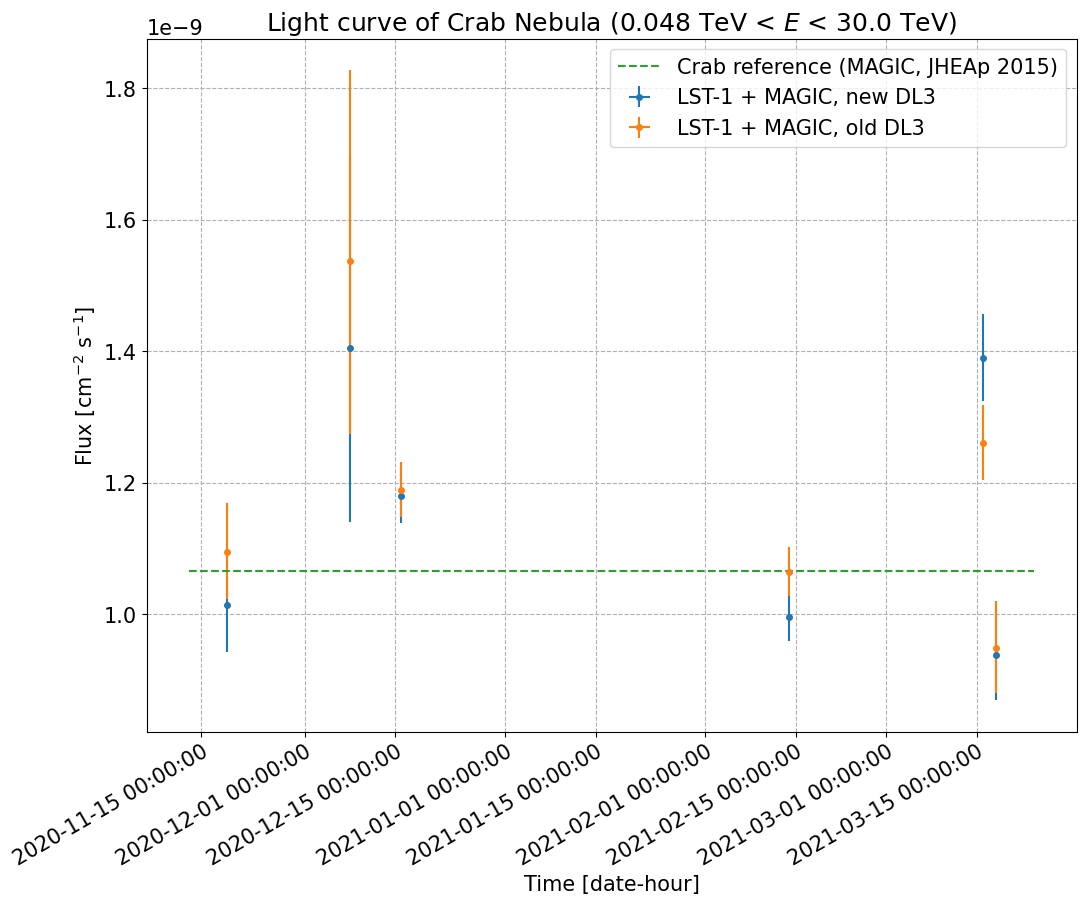

In [113]:
plt.figure()

lines = itertools.cycle(["--", "-.", ":"])

# Plot the light curve
ax = light_curve.plot(sed_type="flux", label="LST-1 + MAGIC, new DL3")
if double:
    ax = light_curve_old.plot(sed_type="flux", label="LST-1 + MAGIC, old DL3")


xlim = plt.xlim()

# Plot the reference flux
for label, model in reference_models.items():
    
    integ_flux = model.integral(energy_edges[0], energy_edges[1])
    ax.plot(xlim, np.repeat(integ_flux, 2), label=label, linestyle=next(lines))

energy_range = f"{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}"

ax.set_title(f"Light curve of {source_name} ({energy_range})")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Time [date-hour]")
ax.set_yscale("linear")
ax.legend()
ax.grid()
